In [1]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import analysis_utils as au
import CMR_IA as cmr
from matplotlib.lines import Line2D
from scipy.stats import norm
# from sklearn.linear_model import LinearRegression
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
SAVEFIG = True

In [70]:
with open("simu1_data/simu1_design.pkl", 'rb') as inp:
    df = pickle.load(inp)
# df = df.loc[df.session < 500]
df

,subject_ID,position,item,itemno,category_label,lag,old,session,study_itemno1,study_itemno2,test_itemno1,test_itemno2
0,58,0,UNDERWEAR,282,Clothing,0,False,0,282,-1,282,-1
1,58,1,JEANS,139,Clothing,0,False,0,139,-1,139,-1
2,58,2,JACKET,138,Clothing,0,False,0,138,-1,138,-1
3,58,3,TABLET,263,Electronics,0,False,0,263,-1,263,-1
4,58,4,COMPUTER,62,Electronics,0,False,0,62,-1,62,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
579995,337,575,LAKE,148,Landscapes,0,False,999,148,-1,148,-1
579996,337,576,PIE,201,Desserts,78,True,999,201,-1,201,-1
579997,337,577,LOBSTER,160,OceanAnimals,90,True,999,160,-1,160,-1
579998,337,578,MAPLE,161,Trees,118,True,999,161,-1,161,-1


### Run CMR-IA

In [71]:
s_mat = np.load('simu1_data/simu1_300_smat.npy')

1. s_fc控制FAR两条线的差距（太低反而加剧差异，高能控制FAR的斜率）
2. c_thresh_item控制FAR的高低
3. gamma控制HR的高低
4. beta控制HR的曲率

In [72]:
# 0.07763692 0.29688559 0.30202563 0.32527225 0.62870206
# 0.07203608 0.29538901 0.30228773 0.34384433 0.61605076
# 0.06303219 0.0992355  0.21488122 0.19815079 0.76851669
# 0.05135588 0.20492208 0.17292792 0.19230073 0.56064881
# 0.05 0.10 0.05 0.04 0.272
# 0.06 0.01 0.05 0.04 0.317
params = cmr.make_default_params()
params.update(
    beta_enc = 0.06,  # 0.05
    beta_rec_post = 0.05,  # 0.01
    s_fc = 0.15,  # 0.096, 0.08? 0.05?
    gamma_fc = 0.13,  # 0.1
    c_thresh_itm = 0.684,  # 0.415? 0.275?
    use_new_context = True,
)
params

{'beta_enc': 0.06,
 'beta_rec': 0.5,
 'beta_cue': 0.5,
 'beta_rec_post': 0.05,
 'beta_distract': None,
 'phi_s': 2,
 'phi_d': 0.5,
 's_cf': 0,
 's_fc': 0.15,
 'kappa': 0.5,
 'eta': 0.5,
 'omega': 5,
 'alpha': 1,
 'c_thresh': 0.5,
 'c_thresh_itm': 0.684,
 'c_thresh_ass': 0.5,
 'd_ass': 1,
 'lamb': 0.5,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 50,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 20,
 'm': 0,
 'n': 1,
 'c1': 0,
 'thresh_sigma': 0,
 'No_recall': None,
 'var_enc': 1,
 'bad_enc_ratio': 1,
 'gamma_fc': 0.13,
 'gamma_cf': 0.5,
 'use_new_context': True}

In [73]:
df_simu = cmr.run_conti_recog_multi_sess(params,df,s_mat,mode='Continuous')

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [07:37<00:00,  2.19it/s]

CMR Time: 457.6937918663025


In [74]:
df_simu = df_simu.merge(df,on=['session','position','study_itemno1','study_itemno2','test_itemno1','test_itemno2'])
df_simu

,session,position,study_itemno1,study_itemno2,test_itemno1,test_itemno2,s_resp,s_rt,csim,subject_ID,item,itemno,category_label,lag,old
0,0,0,282,-1,282,-1,0.0,0.003206,0.000000,58,UNDERWEAR,282,Clothing,0,False
1,0,1,139,-1,139,-1,0.0,0.005857,0.030122,58,JEANS,139,Clothing,0,False
2,0,2,138,-1,138,-1,0.0,0.010966,0.061483,58,JACKET,138,Clothing,0,False
3,0,3,263,-1,263,-1,0.0,0.015256,0.077991,58,TABLET,263,Electronics,0,False
4,0,4,62,-1,62,-1,0.0,0.030228,0.112182,58,COMPUTER,62,Electronics,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579995,999,575,148,-1,148,-1,0.0,2152.072998,0.670841,337,LAKE,148,Landscapes,0,False
579996,999,576,201,-1,201,-1,1.0,1321.251587,0.721552,337,PIE,201,Desserts,78,True
579997,999,577,160,-1,160,-1,1.0,934.876465,0.738848,337,LOBSTER,160,OceanAnimals,90,True
579998,999,578,161,-1,161,-1,1.0,1237.909912,0.724810,337,MAPLE,161,Trees,118,True


In [75]:
df_simu.to_pickle("simu1_data/simu1_result.pkl")

### Preprocesssing

In [2]:
with open("simu1_data/simu1_result.pkl", 'rb') as inp:
    df_simu = pickle.load(inp)

In [3]:
# manual_csim = 0.65
# df_simu['s_resp'] = df_simu['csim'] > manual_csim
# df_simu

In [4]:
# randomly choose 100 number from 0-999
# np.random.seed(5)
# rand_idx = np.random.choice(1000, 200, replace=False)
# df_simu = df_simu.loc[df_simu.session.isin(rand_idx)]
# df_simu = df_simu.reset_index(drop=True)
# df_simu

In [5]:
# calculate the rolling category length
rolling_window = 9
category_label_dummies = df_simu['category_label'].str.get_dummies()
category_label_dummies.columns = ['cl_' + col for col in category_label_dummies.columns]
category_label_dummies_events = pd.concat([df_simu, category_label_dummies], axis=1) # record the occurrence of every cat label
cl_rolling_sum = category_label_dummies_events.groupby('session').rolling(rolling_window, min_periods=1, on='position')[category_label_dummies.columns].sum().reset_index()
df_rollcat = df_simu.merge(cl_rolling_sum, on=['session', 'position'])
df_simu['roll_cat_label_length'] = df_rollcat.apply(lambda x: x['cl_' + x['category_label']], axis = 1) # how many cat within 10 window
df_simu['roll_cat_label_length'] = df_simu['roll_cat_label_length'] - 1 # how many cat in previous 9 window. not include self

# add rolling category length level
# option = "0-1-2+"
option = "0+1-2+"
# option = "0-1+"
if option == "0-1-2+":
    # option 0: 0, 1, >=2
    df_simu['roll_cat_len_level']= pd.cut(x=df_simu.roll_cat_label_length, 
                                    bins=[0, 1, 2, np.inf], right=False, include_lowest = True,
                                    labels=['0', '1', '>=2']).astype('str')
elif option == "0+1-2+":
    # option 1: 0-1, >=2
    df_simu['roll_cat_len_level']= pd.cut(x=df_simu.roll_cat_label_length, 
                                    bins=[0, 2, np.inf], right=False, include_lowest = True,
                                    labels=['0-1', '>=2']).astype('str')
elif option == "0-1+":
    # option 2: 0, >=1
    df_simu['roll_cat_len_level']= pd.cut(x=df_simu.roll_cat_label_length, 
                                    bins=[0, 1, np.inf], right=False, include_lowest = True,
                                    labels=['0', '>=1']).astype('str')
df_simu

,session,position,study_itemno1,study_itemno2,test_itemno1,test_itemno2,s_resp,s_rt,csim,subject_ID,item,itemno,category_label,lag,old,roll_cat_label_length,roll_cat_len_level
0,0,0,282,-1,282,-1,0.0,0.003206,0.000000,58,UNDERWEAR,282,Clothing,0,False,0.0,0-1
1,0,1,139,-1,139,-1,0.0,0.005857,0.030122,58,JEANS,139,Clothing,0,False,1.0,0-1
2,0,2,138,-1,138,-1,0.0,0.010966,0.061483,58,JACKET,138,Clothing,0,False,2.0,>=2
3,0,3,263,-1,263,-1,0.0,0.015256,0.077991,58,TABLET,263,Electronics,0,False,0.0,0-1
4,0,4,62,-1,62,-1,0.0,0.030228,0.112182,58,COMPUTER,62,Electronics,0,False,1.0,0-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579995,999,575,148,-1,148,-1,0.0,2152.072998,0.670841,337,LAKE,148,Landscapes,0,False,6.0,>=2
579996,999,576,201,-1,201,-1,1.0,1321.251587,0.721552,337,PIE,201,Desserts,78,True,0.0,0-1
579997,999,577,160,-1,160,-1,1.0,934.876465,0.738848,337,LOBSTER,160,OceanAnimals,90,True,0.0,0-1
579998,999,578,161,-1,161,-1,1.0,1237.909912,0.724810,337,MAPLE,161,Trees,118,True,0.0,0-1


In [6]:
# add log and log lag bin
df_simu['log_lag'] = np.log(df_simu['lag'])
df_simu['log_lag_bin'] = pd.cut(df_simu['log_lag'], np.arange(df_simu['log_lag'].max()+1), labels=False, right=False)
df_simu

/Users/bei/anaconda3/envs/cmr/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,session,position,study_itemno1,study_itemno2,test_itemno1,test_itemno2,s_resp,s_rt,csim,subject_ID,item,itemno,category_label,lag,old,roll_cat_label_length,roll_cat_len_level,log_lag,log_lag_bin
0,0,0,282,-1,282,-1,0.0,0.003206,0.000000,58,UNDERWEAR,282,Clothing,0,False,0.0,0-1,-inf,NaN
1,0,1,139,-1,139,-1,0.0,0.005857,0.030122,58,JEANS,139,Clothing,0,False,1.0,0-1,-inf,NaN
2,0,2,138,-1,138,-1,0.0,0.010966,0.061483,58,JACKET,138,Clothing,0,False,2.0,>=2,-inf,NaN
3,0,3,263,-1,263,-1,0.0,0.015256,0.077991,58,TABLET,263,Electronics,0,False,0.0,0-1,-inf,NaN
4,0,4,62,-1,62,-1,0.0,0.030228,0.112182,58,COMPUTER,62,Electronics,0,False,1.0,0-1,-inf,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579995,999,575,148,-1,148,-1,0.0,2152.072998,0.670841,337,LAKE,148,Landscapes,0,False,6.0,>=2,-inf,NaN
579996,999,576,201,-1,201,-1,1.0,1321.251587,0.721552,337,PIE,201,Desserts,78,True,0.0,0-1,4.356709,4.0
579997,999,577,160,-1,160,-1,1.0,934.876465,0.738848,337,LOBSTER,160,OceanAnimals,90,True,0.0,0-1,4.499810,4.0
579998,999,578,161,-1,161,-1,1.0,1237.909912,0.724810,337,MAPLE,161,Trees,118,True,0.0,0-1,4.770685,4.0


In [7]:
# construct local FAR
# for i in range(1, len(df_simu)):
#     if df_simu.loc[i, 'old'] == False and df_simu.loc[i-1, 'old'] == True:
#         df_simu.loc[i, 'log_lag_bin'] = df_simu.loc[i-1, 'log_lag_bin']
old_vec = df_simu.old.to_numpy()
log_lag_bin_vec = df_simu.log_lag_bin.to_numpy()
position_vec = df_simu.position.to_numpy()
max_position = np.max(position_vec)
log_lag_bin_newpre_lst = []
log_lag_bin_newpost_lst = []
for i in range(len(df_simu)):
    if position_vec[i] > 0:
        if old_vec[i] == False and old_vec[i-1] == True:
            log_lag_bin_newpre_lst.append(log_lag_bin_vec[i-1])
        else:
            log_lag_bin_newpre_lst.append('N')
    else:
        log_lag_bin_newpre_lst.append('N')

    if position_vec[i] < max_position:
        if old_vec[i] == False and old_vec[i+1] == True:
            log_lag_bin_newpost_lst.append(log_lag_bin_vec[i+1])
        else:
            log_lag_bin_newpost_lst.append('N')
    else:
        log_lag_bin_newpost_lst.append('N')

df_simu['log_lag_bin_newpre'] = log_lag_bin_newpre_lst
df_simu['log_lag_bin_newpost'] = log_lag_bin_newpost_lst
df_simu

,session,position,study_itemno1,study_itemno2,test_itemno1,test_itemno2,s_resp,s_rt,csim,subject_ID,...,itemno,category_label,lag,old,roll_cat_label_length,roll_cat_len_level,log_lag,log_lag_bin,log_lag_bin_newpre,log_lag_bin_newpost
0,0,0,282,-1,282,-1,0.0,0.003206,0.000000,58,...,282,Clothing,0,False,0.0,0-1,-inf,NaN,N,N
1,0,1,139,-1,139,-1,0.0,0.005857,0.030122,58,...,139,Clothing,0,False,1.0,0-1,-inf,NaN,N,N
2,0,2,138,-1,138,-1,0.0,0.010966,0.061483,58,...,138,Clothing,0,False,2.0,>=2,-inf,NaN,N,N
3,0,3,263,-1,263,-1,0.0,0.015256,0.077991,58,...,263,Electronics,0,False,0.0,0-1,-inf,NaN,N,N
4,0,4,62,-1,62,-1,0.0,0.030228,0.112182,58,...,62,Electronics,0,False,1.0,0-1,-inf,NaN,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579995,999,575,148,-1,148,-1,0.0,2152.072998,0.670841,337,...,148,Landscapes,0,False,6.0,>=2,-inf,NaN,N,4.0
579996,999,576,201,-1,201,-1,1.0,1321.251587,0.721552,337,...,201,Desserts,78,True,0.0,0-1,4.356709,4.0,N,N
579997,999,577,160,-1,160,-1,1.0,934.876465,0.738848,337,...,160,OceanAnimals,90,True,0.0,0-1,4.499810,4.0,N,N
579998,999,578,161,-1,161,-1,1.0,1237.909912,0.724810,337,...,161,Trees,118,True,0.0,0-1,4.770685,4.0,N,N


In [8]:
df_simu['log_lag_bin'] = df_simu.apply(lambda x: 0 if x['log_lag_bin'] == 1 else x['log_lag_bin'], axis = 1)
df_simu['log_lag_bin_newpre'] = df_simu.apply(lambda x: 0 if x['log_lag_bin_newpre'] == 1 else x['log_lag_bin_newpre'], axis = 1)
df_simu['log_lag_bin_newpost'] = df_simu.apply(lambda x: 0 if x['log_lag_bin_newpost'] == 1 else x['log_lag_bin_newpost'], axis = 1)
# distribute items into bins
log_lag_bins = [0, 2, 3, 4, 5]
for bin in log_lag_bins:
    col_name = "log_lag_bin_" + str(bin)
    df_simu[col_name] = (df_simu.log_lag_bin == bin) | (df_simu.log_lag_bin_newpre == bin) | (df_simu.log_lag_bin_newpost == bin)
df_simu

,session,position,study_itemno1,study_itemno2,test_itemno1,test_itemno2,s_resp,s_rt,csim,subject_ID,...,roll_cat_len_level,log_lag,log_lag_bin,log_lag_bin_newpre,log_lag_bin_newpost,log_lag_bin_0,log_lag_bin_2,log_lag_bin_3,log_lag_bin_4,log_lag_bin_5
0,0,0,282,-1,282,-1,0.0,0.003206,0.000000,58,...,0-1,-inf,NaN,N,N,False,False,False,False,False
1,0,1,139,-1,139,-1,0.0,0.005857,0.030122,58,...,0-1,-inf,NaN,N,N,False,False,False,False,False
2,0,2,138,-1,138,-1,0.0,0.010966,0.061483,58,...,>=2,-inf,NaN,N,N,False,False,False,False,False
3,0,3,263,-1,263,-1,0.0,0.015256,0.077991,58,...,0-1,-inf,NaN,N,N,False,False,False,False,False
4,0,4,62,-1,62,-1,0.0,0.030228,0.112182,58,...,0-1,-inf,NaN,N,N,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579995,999,575,148,-1,148,-1,0.0,2152.072998,0.670841,337,...,>=2,-inf,NaN,N,4.0,False,False,False,True,False
579996,999,576,201,-1,201,-1,1.0,1321.251587,0.721552,337,...,0-1,4.356709,4.0,N,N,False,False,False,True,False
579997,999,577,160,-1,160,-1,1.0,934.876465,0.738848,337,...,0-1,4.499810,4.0,N,N,False,False,False,True,False
579998,999,578,161,-1,161,-1,1.0,1237.909912,0.724810,337,...,0-1,4.770685,4.0,N,N,False,False,False,True,False


In [9]:
df_simu.groupby(["old", "log_lag_bin", "roll_cat_len_level"]).s_resp.count()

old   log_lag_bin  roll_cat_len_level
True  0.0          0-1                   18927
                   >=2                   36932
      2.0          0-1                   46905
                   >=2                   17855
      3.0          0-1                   76209
                   >=2                    8422
      4.0          0-1                   57684
                   >=2                    3563
      5.0          0-1                   12817
                   >=2                     574
      6.0          0-1                     112
Name: s_resp, dtype: int64

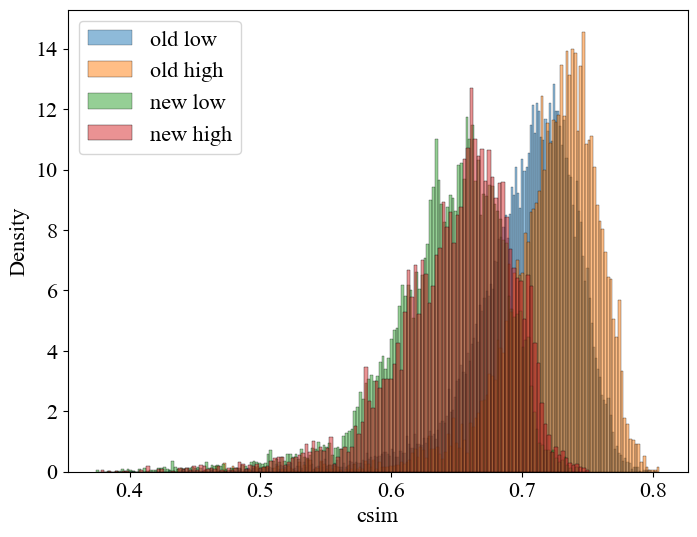

In [10]:
df_csim = df_simu.query("log_lag_bin_0 == True or log_lag_bin_2 == True or log_lag_bin_3 == True or log_lag_bin_4 == True or log_lag_bin_5 == True")

# plot histogram of csim, group by roll_cat_len_level and old
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(df_csim.query("old == True and roll_cat_len_level == '0-1'"), x='csim', alpha=0.5, ax=ax, stat='density', label='old low')
sns.histplot(df_csim.query("old == True and roll_cat_len_level == '>=2'"), x='csim', alpha=0.5, ax=ax, stat='density', label='old high')
sns.histplot(df_csim.query("old == False and roll_cat_len_level == '0-1'"), x='csim', alpha=0.5, ax=ax, stat='density', label='new low')
sns.histplot(df_csim.query("old == False and roll_cat_len_level == '>=2'"), x='csim', alpha=0.5, ax=ax, stat='density', label='new high')
plt.legend()
plt.show()

### Recency & Similarity

In [11]:
df_lst = []
for bin in log_lag_bins:
    col_name = "log_lag_bin_" + str(bin)
    df_tmp = df_simu.query(col_name + " == True").groupby(["session", "old", "roll_cat_len_level"])['s_resp'].agg(['mean', 'sum', 'count']).reset_index()
    df_tmp["log_lag_bin"] = bin
    df_lst.append(df_tmp)
df_rollcat_laggp = pd.concat(df_lst)
df_rollcat_laggp.rename(columns={'mean': 'yes_rate'}, inplace=True)
df_rollcat_laggp['yes_rate_adj'] = (df_rollcat_laggp['sum'] + 0.5) / (df_rollcat_laggp['count'] + 1)
df_rollcat_laggp

,session,old,roll_cat_len_level,yes_rate,sum,count,log_lag_bin,yes_rate_adj
0,0,False,0-1,0.227273,5.0,22,0,0.239130
1,0,False,>=2,0.090909,1.0,11,0,0.125000
2,0,True,0-1,1.000000,3.0,3,0,0.875000
3,0,True,>=2,0.851852,23.0,27,0,0.839286
4,1,False,0-1,0.150000,6.0,40,0,0.158537
...,...,...,...,...,...,...,...,...
2681,998,False,>=2,0.222222,2.0,9,5,0.250000
2682,998,True,0-1,0.660377,35.0,53,5,0.657407
2683,999,False,0-1,0.000000,0.0,1,5,0.250000
2684,999,False,>=2,1.000000,1.0,1,5,0.750000


In [12]:
# # mean of log bin for every subject
# df_simu['log_lag_bin'] = df_simu.apply(lambda x: 0 if x['log_lag_bin'] == 1 else x['log_lag_bin'], axis = 1)
# df_5 = df_simu.query('log_lag_bin <= 5')

# # count and add 0.5 / 1 to numerator / denominator, to avoid 0 and 1
# df_rollcat_laggp = df_5.groupby(['session','old','roll_cat_len_level','log_lag_bin'])['s_resp'].agg(['mean', 'sum', 'count']).reset_index()
# df_rollcat_laggp.rename(columns={'mean': 'yes_rate'}, inplace=True)
# df_rollcat_laggp['yes_rate_adj'] = (df_rollcat_laggp['sum'] + 0.5) / (df_rollcat_laggp['count'] + 1)
# # df_rollcat_laggp = df_5.groupby(['subject_ID','old','roll_cat_len_level','log_lag_bin'])['yes'].mean().to_frame(name='yes_rate').reset_index()

In [13]:
# log lag for display
df_rollcat_laggp['log_lag_disp'] = np.ceil(np.e**df_rollcat_laggp.log_lag_bin)
df_rollcat_laggp

,session,old,roll_cat_len_level,yes_rate,sum,count,log_lag_bin,yes_rate_adj,log_lag_disp
0,0,False,0-1,0.227273,5.0,22,0,0.239130,1.0
1,0,False,>=2,0.090909,1.0,11,0,0.125000,1.0
2,0,True,0-1,1.000000,3.0,3,0,0.875000,1.0
3,0,True,>=2,0.851852,23.0,27,0,0.839286,1.0
4,1,False,0-1,0.150000,6.0,40,0,0.158537,1.0
...,...,...,...,...,...,...,...,...,...
2681,998,False,>=2,0.222222,2.0,9,5,0.250000,149.0
2682,998,True,0-1,0.660377,35.0,53,5,0.657407,149.0
2683,999,False,0-1,0.000000,0.0,1,5,0.250000,149.0
2684,999,False,>=2,1.000000,1.0,1,5,0.750000,149.0


In [14]:
# pivot for hr and far
df_rollcat_laggp['old'] = df_rollcat_laggp['old'].astype('str')
df_dprime = pd.pivot_table(df_rollcat_laggp, values=['yes_rate', 'yes_rate_adj'], index=['session', 'roll_cat_len_level', 'log_lag_disp'], columns='old').reset_index()
df_dprime.columns = [' '.join(col).strip() for col in df_dprime.columns.values]
df_dprime = df_dprime.rename(columns={'yes_rate False': 'far', 'yes_rate True': 'hr', 'yes_rate_adj False': 'far_adj', 'yes_rate_adj True': 'hr_adj'})

# df_dprime = au.loftus_masson(df_dprime, 'subject_ID', ['roll_cat_len_level', 'log_lag_disp'], 'hr') - previous wrong!!
df_dprime

,session,roll_cat_len_level,log_lag_disp,far,hr,far_adj,hr_adj
0,0,0-1,1.0,0.227273,1.000000,0.239130,0.875000
1,0,0-1,8.0,0.296296,0.789474,0.303571,0.782051
2,0,0-1,21.0,0.232143,0.797753,0.236842,0.794444
3,0,0-1,55.0,0.173913,0.685714,0.180851,0.683099
4,0,0-1,149.0,0.052632,0.750000,0.075000,0.741379
...,...,...,...,...,...,...,...
9588,999,>=2,1.0,0.161290,0.884615,0.171875,0.877358
9589,999,>=2,8.0,0.130435,0.958333,0.145833,0.940000
9590,999,>=2,21.0,0.111111,0.750000,0.125000,0.700000
9591,999,>=2,55.0,0.230769,0.500000,0.250000,0.500000


In [15]:
# calculate dprime
df_dprime['z_hr'] = norm.ppf(df_dprime['hr_adj'])
df_dprime['z_far'] = norm.ppf(df_dprime['far_adj'])
df_dprime['dprime'] = df_dprime['z_hr'] - df_dprime['z_far']
df_dprime

,session,roll_cat_len_level,log_lag_disp,far,hr,far_adj,hr_adj,z_hr,z_far,dprime
0,0,0-1,1.0,0.227273,1.000000,0.239130,0.875000,1.150349,-0.709103,1.859452
1,0,0-1,8.0,0.296296,0.789474,0.303571,0.782051,0.779140,-0.514156,1.293296
2,0,0-1,21.0,0.232143,0.797753,0.236842,0.794444,0.821940,-0.716498,1.538437
3,0,0-1,55.0,0.173913,0.685714,0.180851,0.683099,0.476381,-0.912127,1.388508
4,0,0-1,149.0,0.052632,0.750000,0.075000,0.741379,0.647604,-1.439531,2.087135
...,...,...,...,...,...,...,...,...,...,...
9588,999,>=2,1.0,0.161290,0.884615,0.171875,0.877358,1.161883,-0.946782,2.108665
9589,999,>=2,8.0,0.130435,0.958333,0.145833,0.940000,1.554774,-1.054472,2.609246
9590,999,>=2,21.0,0.111111,0.750000,0.125000,0.700000,0.524401,-1.150349,1.674750
9591,999,>=2,55.0,0.230769,0.500000,0.250000,0.500000,0.000000,-0.674490,0.674490


#### HR

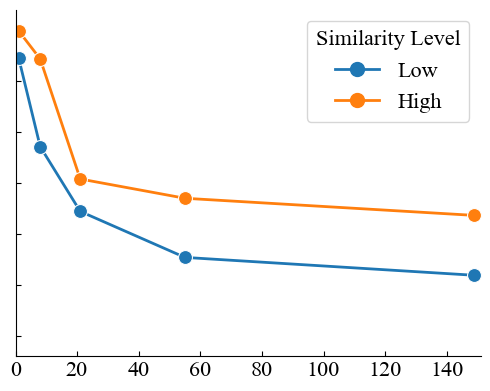

In [27]:
fig, ax = plt.subplots(figsize=(6,4.5))
# fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_dprime, y='hr', x='log_lag_disp', hue = 'roll_cat_len_level', marker = 'o', markersize = 10, linestyle='-', lw=2, ax=ax, errorbar=None)
plt.ylabel('P("Yes" | Old)')
plt.xlabel('Lag')
# selected_lag = np.array([1,np.e,np.e**2,np.e**3,np.e**4,np.e**5])
# plt.xticks(ticks=selected_lag, labels = ['1','e','e2','e3','e4','e5'])
plt.xticks(ticks=np.arange(0,160,20))
plt.ylim([0.58,0.92])
plt.xlim([0,151])
legend_elements = [Line2D([0], [0], color = sns.color_palette()[0], lw=2, marker='o', markersize = 10, linestyle='-',label = 'Low'),
                   Line2D([0], [0], color = sns.color_palette()[1], lw=2, marker='o', markersize = 10, linestyle='-', label = 'High')]
plt.legend(handles = legend_elements, title = "Similarity Level")

if SAVEFIG:
    ax.set(xlabel=None, ylabel=None)
    plt.tick_params(labelleft=False)
    plt.savefig(f'simu1_fig/simu1_hr_{option}.pdf')

#### FAR

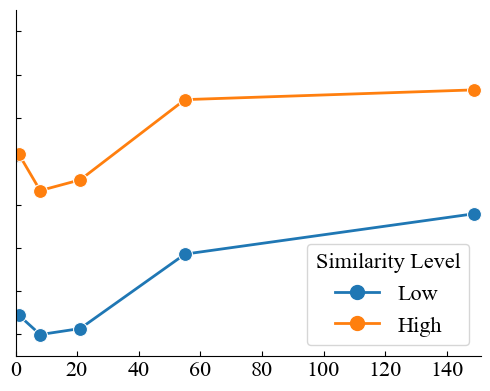

In [28]:
fig, ax = plt.subplots(figsize=(6,4.5))
# fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_dprime, y='far', x='log_lag_disp', hue = 'roll_cat_len_level', marker = 'o', markersize = 10, linestyle='-', lw=2, ax=ax, errorbar=None)
plt.ylabel('P("Yes" | New)')
plt.xlabel('Lag')
# selected_lag = np.array([1,np.e,np.e**2,np.e**3,np.e**4,np.e**5])
# plt.xticks(ticks=selected_lag, labels = ['1','e','e2','e3','e4','e5'])
plt.yticks(ticks=np.arange(0.14, 0.28, 0.02))
plt.xticks(ticks=np.arange(0,160,20))
plt.ylim([0.13,0.29])
plt.xlim([0,151])
legend_elements = [Line2D([0], [0], color = sns.color_palette()[0], lw=2, marker='o', markersize = 10, linestyle='-',label = 'Low'),
                   Line2D([0], [0], color = sns.color_palette()[1], lw=2, marker='o', markersize = 10, linestyle='-', label = 'High')]
plt.legend(handles = legend_elements, title = "Similarity Level", loc='lower right')

if SAVEFIG:
    ax.set(xlabel=None, ylabel=None)
    plt.tick_params(labelleft=False)
    plt.savefig(f'simu1_fig/simu1_far_{option}.pdf')

#### d prime

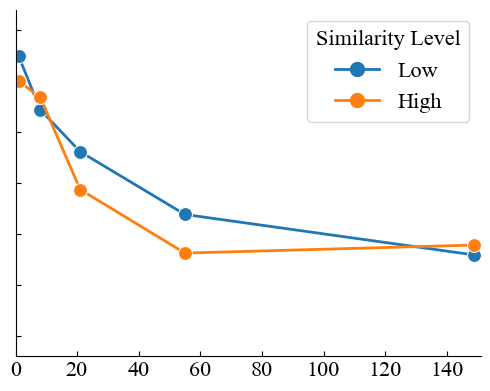

In [29]:
fig, ax = plt.subplots(figsize=(6,4.5))
# fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_dprime, y='dprime', x='log_lag_disp', hue = 'roll_cat_len_level', marker = 'o', markersize = 10, linestyle='-', lw=2, ax=ax, errorbar=None)
plt.ylabel('d prime')
plt.xlabel('Lag')
# selected_lag = np.array([1,np.e,np.e**2,np.e**3,np.e**4,np.e**5])
# plt.xticks(ticks=selected_lag, labels = ['1','e','e2','e3','e4','e5'])
plt.xticks(ticks=np.arange(0,160,20))
plt.ylim([0.65, 2.35])
plt.xlim([0,151])
legend_elements = [Line2D([0], [0], color = sns.color_palette()[0], lw=2, marker='o', markersize = 10, linestyle='-',label = 'Low'),
                   Line2D([0], [0], color = sns.color_palette()[1], lw=2, marker='o', markersize = 10, linestyle='-', label = 'High')]
plt.legend(handles = legend_elements, title = "Similarity Level")

if SAVEFIG:
    ax.set(xlabel=None, ylabel=None)
    plt.tick_params(labelleft=False)
    plt.savefig(f'simu1_fig/simu1_dprime_{option}.pdf')

In [30]:
df_hrfar = df_dprime.groupby(['roll_cat_len_level', 'log_lag_disp'])[['hr', 'far']].mean().reset_index()
hr_lowsim = df_hrfar.query('roll_cat_len_level == "0-1"').hr.to_numpy()
hr_highsim = df_hrfar.query('roll_cat_len_level == ">=2"').hr.to_numpy()
far_lowsim = df_hrfar.query('roll_cat_len_level == "0-1"').far.to_numpy()
far_highsim = df_hrfar.query('roll_cat_len_level == ">=2"').far.to_numpy()
hr_lowsim, hr_highsim, far_lowsim, far_highsim

(array([0.87262239, 0.78556762, 0.72202913, 0.67687946, 0.6593389 ]),
 array([0.89915085, 0.87164757, 0.75382572, 0.7349098 , 0.71810089]),
 array([0.14897251, 0.13995853, 0.14274362, 0.17711164, 0.19575941]),
 array([0.22340865, 0.20645032, 0.21140948, 0.24844621, 0.25295065]))

In [31]:
hr_lowsim_gt = np.array([0.885, 0.853, 0.787, 0.682, 0.630])
hr_highsim_gt = np.array([0.893, 0.858, 0.795, 0.720, 0.671])
far_lowsim_gt = np.array([0.190, 0.190, 0.190, 0.195, 0.212])
far_highsim_gt = np.array([0.202, 0.210, 0.216, 0.229, 0.237]) # a bit diff from real gt
pow_err = np.mean(np.power(hr_lowsim - hr_lowsim_gt, 2)) + np.mean(np.power(hr_highsim - hr_highsim_gt, 2)) \
    + np.mean(np.power(far_lowsim - far_lowsim_gt, 2)) + np.mean(np.power(far_highsim - far_highsim_gt, 2))
abs_err = np.mean(np.abs(hr_lowsim - hr_lowsim_gt)) + np.mean(np.abs(hr_highsim - hr_highsim_gt)) \
    + np.mean(np.abs(far_lowsim - far_lowsim_gt)) + np.mean(np.abs(far_highsim - far_highsim_gt))
err = pow_err + abs_err / 10
err

0.01525200206949653

### Az

In [32]:
def calculate_Az(df_tmp1):
    log_lag_bins = [0, 2, 3, 4, 5]
    Azs = []
    for bin in log_lag_bins:

        # get the df of this log_lag_bin
        col_name = "log_lag_bin_" + str(bin)
        df_tmp = df_tmp1.query(col_name + " == True").copy()

        # get variables
        conf = df_tmp.csim.to_numpy()
        truth = df_tmp.old.to_numpy()
        old_num = np.sum(truth)
        new_num = np.sum(~truth)
        is_old = truth
        is_new = ~truth

        if np.sum(truth) == 0 or np.sum(~truth) == 0:
            Azs.append(np.nan)
            continue
        
        # min_conf = np.round(np.min(conf), 2)
        # max_conf = np.round(np.max(conf), 2)
        # if max_conf - min_conf < 0.05:  # 0.1
        #     Azs.append(np.nan)
        #     continue

        # calculate HR and FAR for different thresholds
        # step = 0.02  # 0.02
        # thresholds = np.arange(min_conf+step, max_conf, step)
        # 0.15~0.42: low; 0.15~0.39: high; 0.18~0.39: weird; 0.18~0.42: low but fit
        min_thresh = 0.45
        max_thresh = 0.75
        thresholds = np.linspace(min_thresh, max_thresh, 7)  # this affects Az
        hrs = []
        fars = []
        old_conf = conf * is_old
        new_conf = conf * is_new
        for thresh in thresholds:
            # hr = (np.sum((conf > thresh) & is_old) + 0.5) / (old_num + 1)
            # far = (np.sum((conf > thresh) & is_new) + 0.5) / (new_num + 1)
            hr = (np.sum(old_conf > thresh) + 0.5) / (old_num + 1)
            far = (np.sum(new_conf > thresh) + 0.5) / (new_num + 1)
            hrs.append(hr)
            fars.append(far)

        # calculate z_hr and z_far
        z_hr = norm.ppf(hrs)
        z_far = norm.ppf(fars)

        # # linear regression on z_hr and z_far using sklearn
        # X = np.array(z_far).reshape(-1, 1)
        # y = np.array(z_hr)
        # reg = LinearRegression().fit(X, y)
        # # get slope and intercept 
        # slope = reg.coef_[0]
        # intercept = reg.intercept_

        try:
            # linear regression on z_hr and z_far manually
            n = len(z_far)
            X = np.column_stack((np.ones(n), z_far))
            beta = np.linalg.inv(X.T @ X) @ X.T @ z_hr
            intercept, slope = beta
        except:
            print("fail")
            Azs.append(np.nan)

        # get A_z
        Az = norm.cdf(intercept/np.sqrt(1+slope**2))
        Azs.append(Az)


    # df to return
    df_return = pd.DataFrame({'log_lag_bin': log_lag_bins, 'Az': Azs})
    
    return df_return

In [33]:
df_Az = df_simu.groupby(["session", "roll_cat_len_level"]).apply(calculate_Az).reset_index()
df_Az.drop(columns = 'level_2', inplace = True)
df_Az['log_lag_disp'] = np.ceil(np.e**df_Az.log_lag_bin)
df_Az

/var/folders/js/fb9kwys10ln8jgq1bxxqg0tr0000gn/T/ipykernel_3620/1777967579.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_Az = df_simu.groupby(["session", "roll_cat_len_level"]).apply(calculate_Az).reset_index()


,session,roll_cat_len_level,log_lag_bin,Az,log_lag_disp
0,0,0-1,0,0.803951,1.0
1,0,0-1,2,0.752935,8.0
2,0,0-1,3,0.726831,21.0
3,0,0-1,4,0.709895,55.0
4,0,0-1,5,0.693443,149.0
...,...,...,...,...,...
9995,999,>=2,0,0.875435,1.0
9996,999,>=2,2,0.860089,8.0
9997,999,>=2,3,0.665022,21.0
9998,999,>=2,4,0.594078,55.0


In [34]:
# pickup those rows where Az is Nan in df_Az
df_Az.loc[df_Az.Az.isna()]

,session,roll_cat_len_level,log_lag_bin,Az,log_lag_disp
19,1,>=2,5,NaN,149.0
29,2,>=2,5,NaN,149.0
38,3,>=2,4,NaN,55.0
59,5,>=2,5,NaN,149.0
74,7,0-1,5,NaN,149.0
...,...,...,...,...,...
9969,996,>=2,5,NaN,149.0
9974,997,0-1,5,NaN,149.0
9979,997,>=2,5,NaN,149.0
9989,998,>=2,5,NaN,149.0


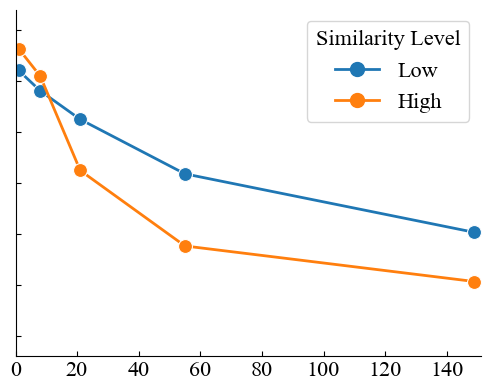

In [35]:
fig, ax = plt.subplots(figsize=(6,4.5))
# fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_Az, y='Az', x='log_lag_disp', hue = 'roll_cat_len_level', marker = 'o', markersize = 10, linestyle='-', lw=2, ax=ax, errorbar=None)
plt.ylabel('$A_z$')
plt.xlabel('Lag')
# selected_lag = np.array([1,np.e,np.e**2,np.e**3,np.e**4,np.e**5])
# plt.xticks(ticks=selected_lag, labels = ['1','e','e2','e3','e4','e5'])
plt.xticks(ticks=np.arange(0,160,20))
plt.ylim([0.53, 0.87])
plt.xlim([0,151])
legend_elements = [Line2D([0], [0], color = sns.color_palette()[0], lw=2, marker='o', markersize = 10, linestyle='-',label = 'Low'),
                   Line2D([0], [0], color = sns.color_palette()[1], lw=2, marker='o', markersize = 10, linestyle='-', label = 'High')]
plt.legend(handles = legend_elements, title = "Similarity Level")

if SAVEFIG:
    ax.set(xlabel=None, ylabel=None)
    plt.tick_params(labelleft=False)
    plt.savefig(f'simu1_fig/simu1_Az_{option}.pdf')

In [36]:
df_plot = df_Az.groupby(["roll_cat_len_level", "log_lag_bin"]).Az.mean().to_frame(name="Az").reset_index()
Az_lowsim = df_plot.query("roll_cat_len_level == '0-1'").Az.to_numpy()
Az_highsim = df_plot.query("roll_cat_len_level == '>=2'").Az.to_numpy()
Az_lowsim, Az_highsim

(array([0.81032337, 0.79036901, 0.76232659, 0.70888042, 0.65146165]),
 array([0.83164966, 0.80480707, 0.71219374, 0.63811328, 0.60320983]))

In [37]:
# ground truth
# Az_lowsim_gt = np.array([0.82, 0.82, 0.80, 0.73, 0.63])
# Az_highsim_gt = np.array([0.81, 0.78, 0.76, 0.69, 0.61])
Az_lowsim_gt = np.array([0.79422725, 0.80266184, 0.78106113, 0.71072426, 0.63710236])
Az_highsim_gt = np.array([0.78978756, 0.77160788, 0.73594832, 0.66568966, 0.62507146])

# calculate the error
err = np.mean(np.power(Az_lowsim - Az_lowsim_gt, 2)) + np.mean(np.power(Az_highsim - Az_highsim_gt, 2))
err

0.0011256119569237793